# Adding Noise

I found that my models performed well on training and validation sets, but they struggled on the test set. Initially, the I ran a heuristic using the grammar counts and found it to perform well on the training and validation sets. When I submitted the heuristic on the test set, it performed a lot worse. This leads me to believe that the grammar is the test data is noisy. Perhaps the hosts decided to add grammar errors to the LLM essays to prevent people from using my heuristic. Hence, I am going to add some noise to the grammar errors in the training set to see how performance is affected. 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier 
from catboost import CatBoostClassifier
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pickle 
import tqdm

%matplotlib inline

In [2]:
# Getting the data
training_data = pd.read_csv('../../data/train.csv')
valid_data = pd.read_csv('../../data/validation.csv')

In [3]:
# Adding Gaussian Noise and absolute valuing it to maintain positives in grammar errors
noise = np.random.normal(0,7,training_data.shape[0])
training_data['grammar_errors'] = np.abs(training_data['grammar_errors'] + noise)

In [4]:
# Dropping and scaling
X_train = training_data.drop(['LLM_written','prompt','essay','row_id'],axis=1)
y_train = training_data['LLM_written'].values

X_valid = valid_data.drop(['LLM_written','prompt','essay','row_id'],axis=1)
y_valid = valid_data['LLM_written'].values

In [5]:
# Creating a scalar and scaling the data
numerical = ['word_count','stop_word_count','stop_word_ratio','unique_word_count','unique_word_ratio',
             'count_question','count_exclamation','count_semi','count_colon','grammar_errors']
scalar = RobustScaler()
X_train[numerical] = scalar.fit_transform(X_train[numerical])
X_valid[numerical] = scalar.transform(X_valid[numerical])

In [6]:
# Saving the scalar
with open('../../models/custom-features/noisy-grammar-errors/scalar-noisy.pkl','wb') as file:
    pickle.dump(scalar,file)

In [7]:
# Creating a dictionary for the model performances
performances = {
    'model':[],
    'Train ROC AUC':[],
    'Valid ROC AUC':[]
}

## Random Forest

In [8]:
forest = RandomForestClassifier(n_estimators=1000,criterion='gini',bootstrap=True,random_state=42,class_weight='balanced')
forest.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=1000,
                       random_state=42)

In [9]:
# Making predictions
print('Predictions for Random Forest')
train_preds = forest.predict_proba(X_train)[:,1]
valid_preds = forest.predict_proba(X_valid)[:,1]
train_score = roc_auc_score(y_train,train_preds)
valid_score = roc_auc_score(y_valid,valid_preds)
print(f'Training ROC AUC: {train_score}')
print(f'Validation ROC AUC: {valid_score}')

Predictions for Random Forest
Training ROC AUC: 0.9999999999999999
Validation ROC AUC: 0.9790311497751699


In [10]:
# Adding the metrics
model = 'Random Forest'
performances['model'].append(model)
performances['Train ROC AUC'].append(train_score)
performances['Valid ROC AUC'].append(valid_score)

In [11]:
# Saving the model
with open('../../models/custom-features/noisy-grammar-errors/forest-noisy.pkl','wb') as file:
    pickle.dump(forest,file)

## Gradient Boosting

In [12]:
# Creating the balanced class sample weights
sample_weights =  X_train.shape[0] / (2.0 * np.bincount(y_train.astype(int)))

In [13]:
catboost = CatBoostClassifier(iterations=1000,learning_rate=0.3,loss_function='Logloss',early_stopping_rounds=10,random_seed=42,eval_metric='AUC',
                              class_weights=sample_weights)
catboost.fit(X_train,y_train,eval_set=(X_valid,y_valid),use_best_model=True)

0:	test: 0.8190560	best: 0.8190560 (0)	total: 163ms	remaining: 2m 43s
1:	test: 0.8652213	best: 0.8652213 (1)	total: 259ms	remaining: 2m 9s
2:	test: 0.8803605	best: 0.8803605 (2)	total: 345ms	remaining: 1m 54s
3:	test: 0.9121654	best: 0.9121654 (3)	total: 571ms	remaining: 2m 22s
4:	test: 0.9122913	best: 0.9122913 (4)	total: 778ms	remaining: 2m 34s
5:	test: 0.9118936	best: 0.9122913 (4)	total: 970ms	remaining: 2m 40s
6:	test: 0.9169757	best: 0.9169757 (6)	total: 1.12s	remaining: 2m 39s
7:	test: 0.9338937	best: 0.9338937 (7)	total: 1.25s	remaining: 2m 34s
8:	test: 0.9356246	best: 0.9356246 (8)	total: 1.44s	remaining: 2m 39s
9:	test: 0.9348269	best: 0.9356246 (8)	total: 1.63s	remaining: 2m 41s
10:	test: 0.9340028	best: 0.9356246 (8)	total: 1.9s	remaining: 2m 50s
11:	test: 0.9376996	best: 0.9376996 (11)	total: 2.05s	remaining: 2m 48s
12:	test: 0.9421244	best: 0.9421244 (12)	total: 2.19s	remaining: 2m 45s
13:	test: 0.9427249	best: 0.9427249 (13)	total: 2.28s	remaining: 2m 40s
14:	test: 0.945

In [14]:
# Making predictions
print('Predictions for Gradient Boosting')
train_preds = catboost.predict_proba(X_train)[:,1]
valid_preds = catboost.predict_proba(X_valid)[:,1]
train_score = roc_auc_score(y_train,train_preds)
valid_score = roc_auc_score(y_valid,valid_preds)
print(f'Training ROC AUC: {train_score}')
print(f'Validation ROC AUC: {valid_score}')

Predictions for Gradient Boosting
Training ROC AUC: 0.9974400280375522
Validation ROC AUC: 0.963468013742788


In [15]:
# Adding the metrics
model = 'Gradient Boosting'
performances['model'].append(model)
performances['Train ROC AUC'].append(train_score)
performances['Valid ROC AUC'].append(valid_score)

In [16]:
catboost.save_model('../../models/custom-features/noisy-grammar-errors/catboost-noisy')

## ANN

In [17]:
# Class for the model
class ANN(nn.Module):
    # Constructor
    def __init__(self,num_features,model_layers,include_dropout,dropout_rate):
        # Calling super constructor
        super().__init__()
        self.model = nn.Sequential()

        # Adding the layers
        in_features = num_features
        for index in range(len(model_layers)):
            model_layer = nn.Linear(in_features,model_layers[index],bias=True)
            self.model.append(model_layer)
            self.model.append(nn.ReLU())
            in_features = model_layers[index]

            # Adding dropout if specified
            if include_dropout[index]:
                self.model.append(nn.Dropout(p=dropout_rate))
        
        # Adding the final layer
        self.model.append(nn.Linear(in_features,1))

    # Forward class
    def forward(self,X):
        # Running the input through the model 
        return nn.functional.sigmoid(self.model(X))

In [18]:
# Defining the model
num_features = X_train.shape[1]
layers = [10,20,10]
include_dropout = [True] * 3
dropout_rate = 0.2

model = ANN(num_features,layers,include_dropout,dropout_rate)
model

ANN(
  (model): Sequential(
    (0): Linear(in_features=515, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=10, out_features=20, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=20, out_features=10, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [19]:
# Putting both into Tensors and into a dataloader for iterating
X_train_tensor = torch.from_numpy(X_train.values)
y_train_tensor = torch.from_numpy(y_train)
X_valid_tensor = torch.from_numpy(X_valid.values)
y_valid_tensor = torch.from_numpy(y_valid)
training_dataset = TensorDataset(X_train_tensor,y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor,y_valid_tensor)
training_loader = DataLoader(training_dataset,batch_size=32,shuffle=True)
valid_loader = DataLoader(training_dataset,batch_size=32,shuffle=True)

In [20]:
# Model training
EPOCHS = 100
LEARNING_RATE = 0.003
LOSS = nn.BCELoss()
OPTIMIZER = torch.optim.Adam(model.parameters(),LEARNING_RATE)
history = []
early_stopping_threshold = 10
best_roc_auc = 0
current_count = 0

for epoch in tqdm.tqdm(range(EPOCHS)):
    train_loss = 0
    train_preds = None
    valid_preds = None
    train_targets = None
    valid_targets = None
    for X,y in training_loader:
        # Making predictions
        X = X.to(torch.float32)
        y = y.to(torch.float32)
        pred = model(X)
        if train_preds is None:
            train_preds = pred.detach().numpy()
        else:
            train_preds = np.append(train_preds,pred.detach().numpy(),axis=0)
        
        # Getting the targets
        if train_targets is None:
            train_targets = y.numpy()
        else:
            train_targets = np.append(train_targets,y.detach().numpy(),axis=0)

        # Getting the loss
        loss = LOSS(pred,y.view(-1,1))

        # Calculating the gradients
        loss.backward()

        # Taking a step with the optimizer
        OPTIMIZER.step()

        # Clear the gradients
        OPTIMIZER.zero_grad()

        # Adding the loss
        train_loss += loss.item()
    
    # Going through a validation loop
    model.eval()
    val_loss = 0
    for X,y in valid_loader:
        # Making predictions
        X = X.to(torch.float32)
        y = y.to(torch.float32)
        with torch.no_grad():
            pred = model(X)
            loss = LOSS(pred,y.view(-1,1))

        val_loss += loss.item()
        if valid_preds is None:
            valid_preds = pred.detach().numpy()
        else:
            valid_preds = np.append(valid_preds,pred.detach().numpy(),axis=0)
        
        # Getting the targets
        if valid_targets is None:
            valid_targets = y.numpy()
        else:
            valid_targets = np.append(valid_targets,y.detach().numpy(),axis=0)
    
    # Early Stopping
    if roc_auc_score(valid_targets,valid_preds) - best_roc_auc > 1e-4:
        best_roc_auc = roc_auc_score(valid_targets,valid_preds)
        count = 0

        # Saving the best model
        torch.save(model.state_dict(),'../../models/custom-features/noisy-grammar-errors/ann.pt')
    else:
        count += 1

    # Appending the average example loss to the history
    print(f'----------EPOCH {epoch} loss----------')
    print(f'Train Loss: {train_loss / len(training_loader)}')
    print(f'Valid Loss: {val_loss / len(valid_loader)}')
    print(f'Training ROC AUC: {roc_auc_score(train_targets,train_preds)}')
    print(f'Validation ROC AUC: {roc_auc_score(valid_targets,valid_preds)}')
    history.append([train_loss / len(training_loader),val_loss / len(valid_loader),roc_auc_score(train_targets,train_preds),roc_auc_score(valid_targets,valid_preds)])
    print('--------------------------------------')
    print()

    # Stopping the loop 
    if count == 10:
        print('Found no improvement!')
        break

  1%|          | 1/100 [00:17<28:49, 17.47s/it]

----------EPOCH 0 loss----------
Train Loss: 0.15548073185390615
Valid Loss: 0.07184538585395327
Training ROC AUC: 0.9832093116136904
Validation ROC AUC: 0.996252430926567
--------------------------------------

----------EPOCH 1 loss----------
Train Loss: 0.07213605031569639
Valid Loss: 0.057330823953940305
Training ROC AUC: 0.9960683076029786
Validation ROC AUC: 0.9979391181065036
--------------------------------------



  2%|▏         | 2/100 [00:36<30:29, 18.67s/it]

----------EPOCH 2 loss----------
Train Loss: 0.059960483572211315
Valid Loss: 0.04447883544251581
Training ROC AUC: 0.9973341312899803


  3%|▎         | 3/100 [00:56<30:31, 18.88s/it]

Validation ROC AUC: 0.9986769321134917
--------------------------------------



  4%|▍         | 4/100 [01:14<29:40, 18.55s/it]

----------EPOCH 3 loss----------
Train Loss: 0.050430897343347936
Valid Loss: 0.040965720355305525
Training ROC AUC: 0.9981616749236584
Validation ROC AUC: 0.9989550085364688
--------------------------------------

----------EPOCH 4 loss----------
Train Loss: 0.04500849927231249
Valid Loss: 0.035416259768852654
Training ROC AUC: 0.9984217484027962
Validation ROC AUC: 0.999152898372448


  5%|▌         | 5/100 [01:31<28:23, 17.93s/it]

--------------------------------------



  6%|▌         | 6/100 [01:47<27:32, 17.58s/it]

----------EPOCH 5 loss----------
Train Loss: 0.03987627622783802
Valid Loss: 0.029829606965866798
Training ROC AUC: 0.9987509416961851
Validation ROC AUC: 0.999347364938559
--------------------------------------



  7%|▋         | 7/100 [02:03<26:19, 16.99s/it]

----------EPOCH 6 loss----------
Train Loss: 0.035794999970806256
Valid Loss: 0.02554142341664836
Training ROC AUC: 0.9990005747421732
Validation ROC AUC: 0.9995378229312473
--------------------------------------



  8%|▊         | 8/100 [02:18<25:07, 16.38s/it]

----------EPOCH 7 loss----------
Train Loss: 0.03190407585529926
Valid Loss: 0.025731194350296673
Training ROC AUC: 0.9992243745194599
Validation ROC AUC: 0.999524257279486
--------------------------------------



  9%|▉         | 9/100 [02:34<24:45, 16.33s/it]

----------EPOCH 8 loss----------
Train Loss: 0.029568468095927263
Valid Loss: 0.023589441029243177
Training ROC AUC: 0.9993316297760202
Validation ROC AUC: 0.9996721889733087
--------------------------------------

----------EPOCH 9 loss----------
Train Loss: 0.027177477740001132
Valid Loss: 0.023561887640783805
Training ROC AUC: 0.9994386971307018
Validation ROC AUC: 0.9994458082449228


 10%|█         | 10/100 [02:51<24:33, 16.38s/it]

--------------------------------------



 11%|█         | 11/100 [03:09<24:49, 16.74s/it]

----------EPOCH 10 loss----------
Train Loss: 0.025481793908825687
Valid Loss: 0.017256168723099125
Training ROC AUC: 0.9994326281159828
Validation ROC AUC: 0.9997754205379042
--------------------------------------



 12%|█▏        | 12/100 [03:25<24:17, 16.56s/it]

----------EPOCH 11 loss----------
Train Loss: 0.023146008039745404
Valid Loss: 0.018574911981851412
Training ROC AUC: 0.9995766948625316
Validation ROC AUC: 0.9997470279160207
--------------------------------------



 13%|█▎        | 13/100 [03:42<24:17, 16.75s/it]

----------EPOCH 12 loss----------
Train Loss: 0.021664092393845223
Valid Loss: 0.016021389436626902
Training ROC AUC: 0.9996117342434178
Validation ROC AUC: 0.9998071284400704
--------------------------------------



 14%|█▍        | 14/100 [03:59<24:11, 16.88s/it]

----------EPOCH 13 loss----------
Train Loss: 0.020819074145949638
Valid Loss: 0.015695704585161525
Training ROC AUC: 0.9996259435131097
Validation ROC AUC: 0.9998069351387119
--------------------------------------



 15%|█▌        | 15/100 [04:16<23:58, 16.92s/it]

----------EPOCH 14 loss----------
Train Loss: 0.019129049537795737
Valid Loss: 0.014189964465831392
Training ROC AUC: 0.9996802439165093
Validation ROC AUC: 0.9998383449896212
--------------------------------------



 16%|█▌        | 16/100 [04:32<23:14, 16.60s/it]

----------EPOCH 15 loss----------
Train Loss: 0.01720099637296215
Valid Loss: 0.013706107561415527
Training ROC AUC: 0.9997418433360091
Validation ROC AUC: 0.9998458059901002
--------------------------------------



 17%|█▋        | 17/100 [04:47<22:15, 16.10s/it]

----------EPOCH 16 loss----------
Train Loss: 0.016360417455354815
Valid Loss: 0.012710389209943166
Training ROC AUC: 0.9997625730168885
Validation ROC AUC: 0.9998614148048235
--------------------------------------



 18%|█▊        | 18/100 [05:03<21:53, 16.02s/it]

----------EPOCH 17 loss----------
Train Loss: 0.017467646433461236
Valid Loss: 0.013419286382904126
Training ROC AUC: 0.9996862880936234
Validation ROC AUC: 0.9998484938508895
--------------------------------------



 19%|█▉        | 19/100 [05:20<22:06, 16.38s/it]

----------EPOCH 18 loss----------
Train Loss: 0.015120316519969045
Valid Loss: 0.010860149374303196
Training ROC AUC: 0.999791958063065
Validation ROC AUC: 0.9999080749450316
--------------------------------------



 20%|██        | 20/100 [05:38<22:42, 17.04s/it]

----------EPOCH 19 loss----------
Train Loss: 0.01662468200055376
Valid Loss: 0.012217899381755925
Training ROC AUC: 0.9998015615769252
Validation ROC AUC: 0.9999005199936131
--------------------------------------



 21%|██        | 21/100 [05:57<23:06, 17.55s/it]

----------EPOCH 20 loss----------
Train Loss: 0.014290222890315006
Valid Loss: 0.019663896029190008
Training ROC AUC: 0.9998037310877029
Validation ROC AUC: 0.9996084794373036
--------------------------------------



 22%|██▏       | 22/100 [06:13<22:14, 17.10s/it]

----------EPOCH 21 loss----------
Train Loss: 0.015172626830149137
Valid Loss: 0.010187049774002126
Training ROC AUC: 0.9998244661680614
Validation ROC AUC: 0.9999078341282556
--------------------------------------

----------EPOCH 22 loss----------
Train Loss: 0.013517312973863587
Valid Loss: 0.009767471316964095
Training ROC AUC: 0.9998456407660341
Validation ROC AUC: 0.9999124593222128


 23%|██▎       | 23/100 [06:31<22:07, 17.24s/it]

--------------------------------------



 24%|██▍       | 24/100 [06:48<21:57, 17.34s/it]

----------EPOCH 23 loss----------
Train Loss: 0.011624289319139114
Valid Loss: 0.009239218251122998
Training ROC AUC: 0.9998736856614517
Validation ROC AUC: 0.9999229224331756
--------------------------------------



 25%|██▌       | 25/100 [06:59<19:13, 15.38s/it]

----------EPOCH 24 loss----------
Train Loss: 0.011743819478686773
Valid Loss: 0.008473692603081834
Training ROC AUC: 0.9998741845733378
Validation ROC AUC: 0.9999343380122846
--------------------------------------



 26%|██▌       | 26/100 [07:10<17:05, 13.86s/it]

----------EPOCH 25 loss----------
Train Loss: 0.010703944289423247
Valid Loss: 0.007786346420083328
Training ROC AUC: 0.999888523430533
Validation ROC AUC: 0.9999390398788479
--------------------------------------



 27%|██▋       | 27/100 [07:20<15:36, 12.83s/it]

----------EPOCH 26 loss----------
Train Loss: 0.012211542225723756
Valid Loss: 0.008502485822754686
Training ROC AUC: 0.9998496396203942
Validation ROC AUC: 0.9999292387440456
--------------------------------------



 28%|██▊       | 28/100 [07:31<14:43, 12.27s/it]

----------EPOCH 27 loss----------
Train Loss: 0.011149361385940111
Valid Loss: 0.008331237979871292
Training ROC AUC: 0.9998732893396721
Validation ROC AUC: 0.9999375323442308
--------------------------------------



 28%|██▊       | 28/100 [07:42<19:48, 16.51s/it]

----------EPOCH 28 loss----------
Train Loss: 0.009842425130615649
Valid Loss: 0.009764087401873804
Training ROC AUC: 0.9998994562961935
Validation ROC AUC: 0.9999229191934879
--------------------------------------

Found no improvement!


In [21]:
# Putting history into a dataframe
history_df = pd.DataFrame(history,columns=['Training Loss','Validation Loss','Training ROC AUC','Validation ROC AUC'])

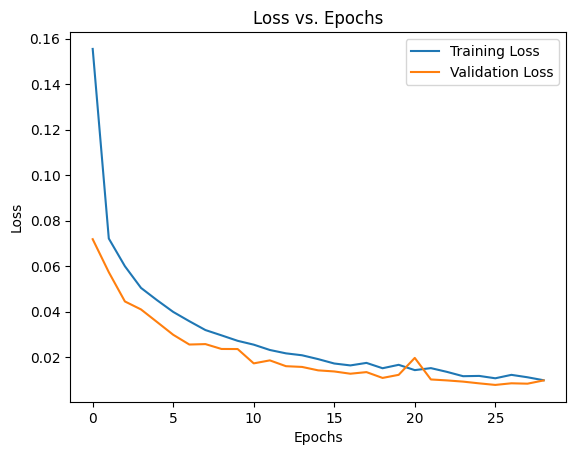

In [22]:
# Plotting the loss
history_df[['Training Loss','Validation Loss']].plot(title='Loss vs. Epochs',xlabel='Epochs',ylabel='Loss')
plt.show()

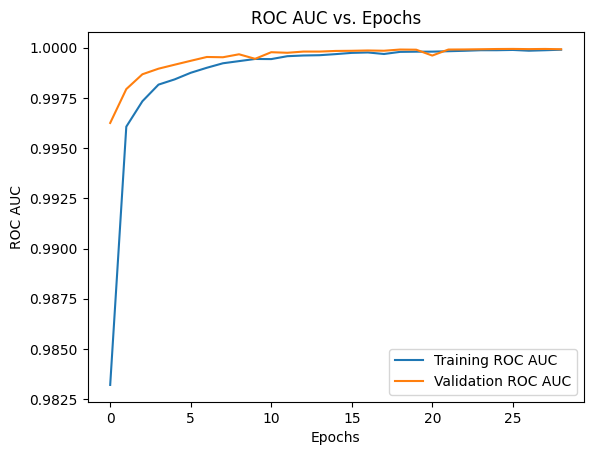

In [23]:
# Plotting the ROC AUC
history_df[['Training ROC AUC','Validation ROC AUC']].plot(title='ROC AUC vs. Epochs',xlabel='Epochs',ylabel='ROC AUC')
plt.show()

In [24]:
# Loading the best model
ann_clf = ANN(num_features,layers,include_dropout,dropout_rate)
ann_clf = torch.load('../../models/custom-features/noisy-grammar-errors/ann.pt')

In [25]:
# Inference loop 
with torch.no_grad():
    model.eval()
    train_preds = None
    val_preds = None
    train_targets = None
    val_targets = None
    for X,y in training_loader:
        # Making predictions
        X = X.to(torch.float32)
        y = y.to(torch.float32)
        pred = model(X)
        if train_preds is None:
            train_preds = pred.detach().numpy()
        else:
            train_preds = np.append(train_preds,pred.detach().numpy(),axis=0)

        # Getting the targets
        if train_targets is None:
            train_targets = y.numpy()
        else:
            train_targets = np.append(train_targets,y.detach().numpy(),axis=0)
    for X,y in valid_loader:
        # Making predictions
        X = X.to(torch.float32)
        y = y.to(torch.float32)
        pred = model(X)
        if valid_preds is None:
            valid_preds = pred.detach().numpy()
        else:
            valid_preds = np.append(valid_preds,pred.detach().numpy(),axis=0)

        # Getting the targets
        if valid_targets is None:
            valid_targets = y.numpy()
        else:
            valid_targets = np.append(valid_targets,y.detach().numpy(),axis=0)

In [26]:
# Making predictions
print('Predictions for ANN')
train_score = roc_auc_score(train_targets,train_preds)
valid_score = roc_auc_score(valid_targets,valid_preds)
print(f'Training ROC AUC: {train_score}')
print(f'Validation ROC AUC: {valid_score}')

Predictions for ANN
Training ROC AUC: 0.999922919193488
Validation ROC AUC: 0.999922919193488


In [27]:
# Adding the metrics
model = 'ANN'
performances['model'].append(model)
performances['Train ROC AUC'].append(train_score)
performances['Valid ROC AUC'].append(valid_score)

In [28]:
# Printing out the model performances in a dataframe and saving it
metrics_df = pd.DataFrame().from_dict(performances)
metrics_df

,model,Train ROC AUC,Valid ROC AUC
0,Random Forest,1.000000,0.979031
1,Gradient Boosting,0.997440,0.963468
2,ANN,0.999923,0.999923


In [29]:
# Saving the performances
metrics_df.to_csv('../../models/custom-features/noisy-grammar-errors/metrics.csv',index=False)

In [30]:
# Saving the noisy training data for future reference if needed
training_data.to_csv('../../data/train-noisy-grammar.csv',index=False)

Some notes here:

1. The added noise revealed overfitting in the Random Forest and Gradient Boosting Models.
2. The ANN maintained similar performance as without the noise. 
3. I am going to submit the ANN to the competition for testing. If there is an improvement in the score, then I am on the right track.
4. Gradient Boosting and Random Forest models seem to "over-rely" on grammar errors.